<span style="font-width:bold; font-size: 3rem; color:#333;">- Part 01: Feature Backfill for Air Quality Data</span>


## 🗒️ You have the following tasks
1. Choose an Air Quality Sensor
2. Update the country, city, and street information to point to YOUR chosen Air Quality Sensor
3. Download historical measures for your Air Quality Sensor as a CSV file
4. Update the path of the CSV file in this notebook to point to the one that you downloaded
5. Create an account on www.hopsworks.ai and get your HOPSWORKS_API_KEY
6. Run this notebook



### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import requests
import pandas as pd
import hopsworks
import datetime
from pathlib import Path
from functions import util
import json
import re
import warnings
warnings.filterwarnings("ignore")

### IF YOU WANT TO WIPE OUT ALL OF YOUR FEATURES AND MODELS, run the cell below

In [2]:
proj = hopsworks.login()
util.purge_project(proj)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.
No air_quality_fv feature view found
No air_quality feature group found
No weather feature group found
No aq_monitoring feature group found
Deleted model air_quality_xgboost_model/1


## <span style='color:#ff5f27'> 🌍 STEP 1: Pick your Air Quality Sensor</span>

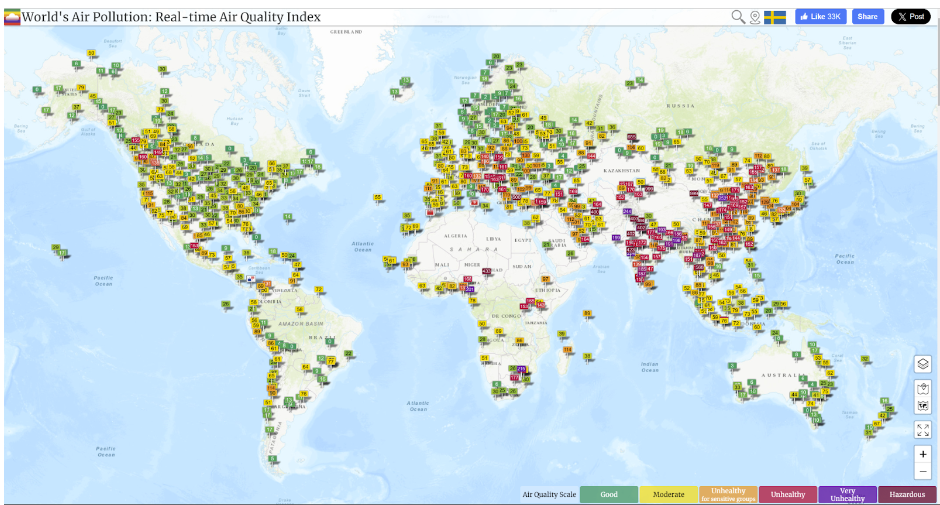

  * Find your favorite sensor on https://waqi.info/ 
  * The sensor will have a URL in the form (see example above): 

  `https://aqicn.org/station/<CITY OR COUNTRY NAME>/<STREET>`
  or
  `https://aqicn.org/station/@36655//`

Some examples of URLs for stations:

 * https://aqicn.org/station/sweden/stockholm-hornsgatan-108-gata/ - in Stockholm, Sweden
 * https://aqicn.org/station/@36655// - in Hell's Kitchen, Manhatten, New York, USA
 * https://aqicn.org/station/nigeria-benin-city-edo-state-secretariat-palm-house/ - in Benin City, Nigeria
 * https://aqicn.org/station/india/mumbai/sion/ - Sion in Mumbai, India

__When you pick a sensor for your project, there are 2 things the sensor MUST have__:
  1. __PM 2.5__ measurements
  2. __Good Historical Values__ for download as a CSV file

__Write down the country, city, and the street for your sensor.__

You will also need the city name, as we will use that to download weather data for your sensor.

## What is an Air Quality Sensor?

For this notebook, the example air quality sensor is here:

 * https://aqicn.org/station/sweden/stockholm-hornsgatan-108-gata/

We can see below that this sensor fulfills our 2 requirements. It has:
  1. __PM 2.5__ measurements (see upper red-ringed value in image below)
  2. __Good Historical Measurements__ (see lower red-ringed values in image below) 

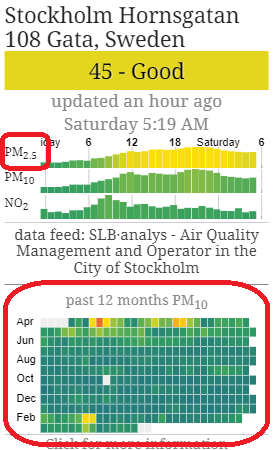

---

## <span style='color:#ff5f27'> 🌍 STEP 2: Download the Historical Air Quality </span>

You can download a CSV file containing the historical air quality data from your your sensor's URL.

For our example sensor, the historical data is available here:

https://aqicn.org/historical#!city:sweden/stockholm-hornsgatan-108-gata

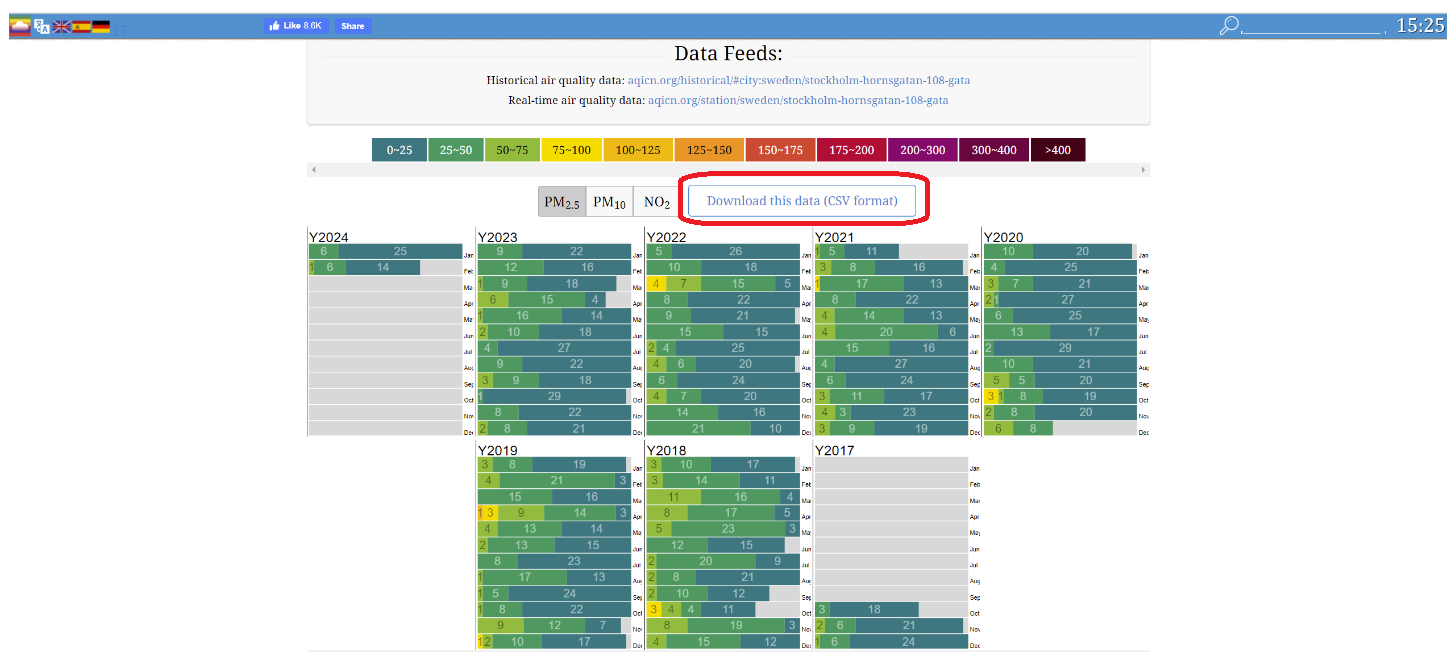

## <span style='color:#ff5f27'> 🌍 STEP 3: Change the AQICN_URL, country, city, street names to match your Sensor </span>

You can find your __AQICN_URL__ if you scroll down the webpage for your sensor - it is the URL inside the redbox here.
You shouldn't include the last part of the url - "/?token=\__YOUR_TOKEN\__". 
It is bad practice to save TOKENs (aka API KEYs) in your source code - you might make it public if you check that code into Github!
We will fill in the token later by saving the AQI_API_KEY as a secret in Hopsworks.

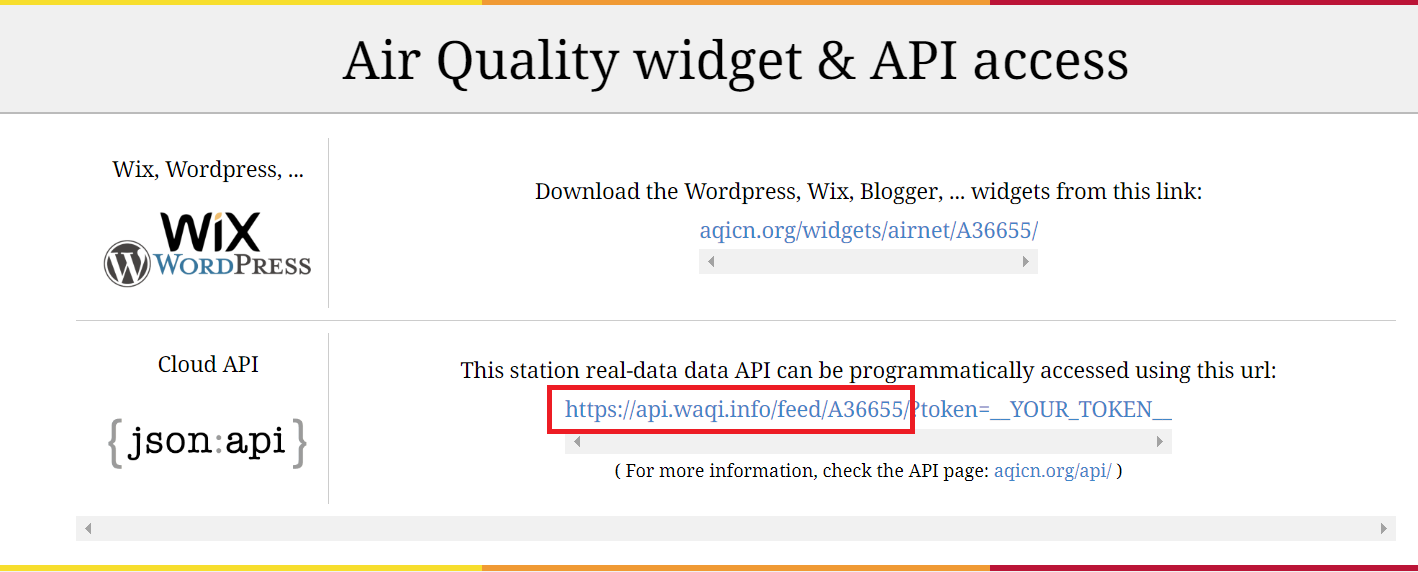

__Update the values in the cell below.__

In [3]:
# My URL for my sensor is:
# https://aqicn.org/sweden/stockholm-hornsgatan-108-gata
country="usa"
city = "new york"
street = "51st and 8th"
aqicn_url="https://api.waqi.info/feed/A36655"

# TODO: Change this path to point to the CSV file you downloaded for your sensor
csv_file="../../data/hells-kitchen.csv"

today = datetime.date.today()

## <span style='color:#ff5f27'> 🌍 STEP 4: Get an AQI API Token and Store it as a Secret in Hopsworks </span>

You have to first get your AQI API key [from here](https://aqicn.org/data-platform/token/):

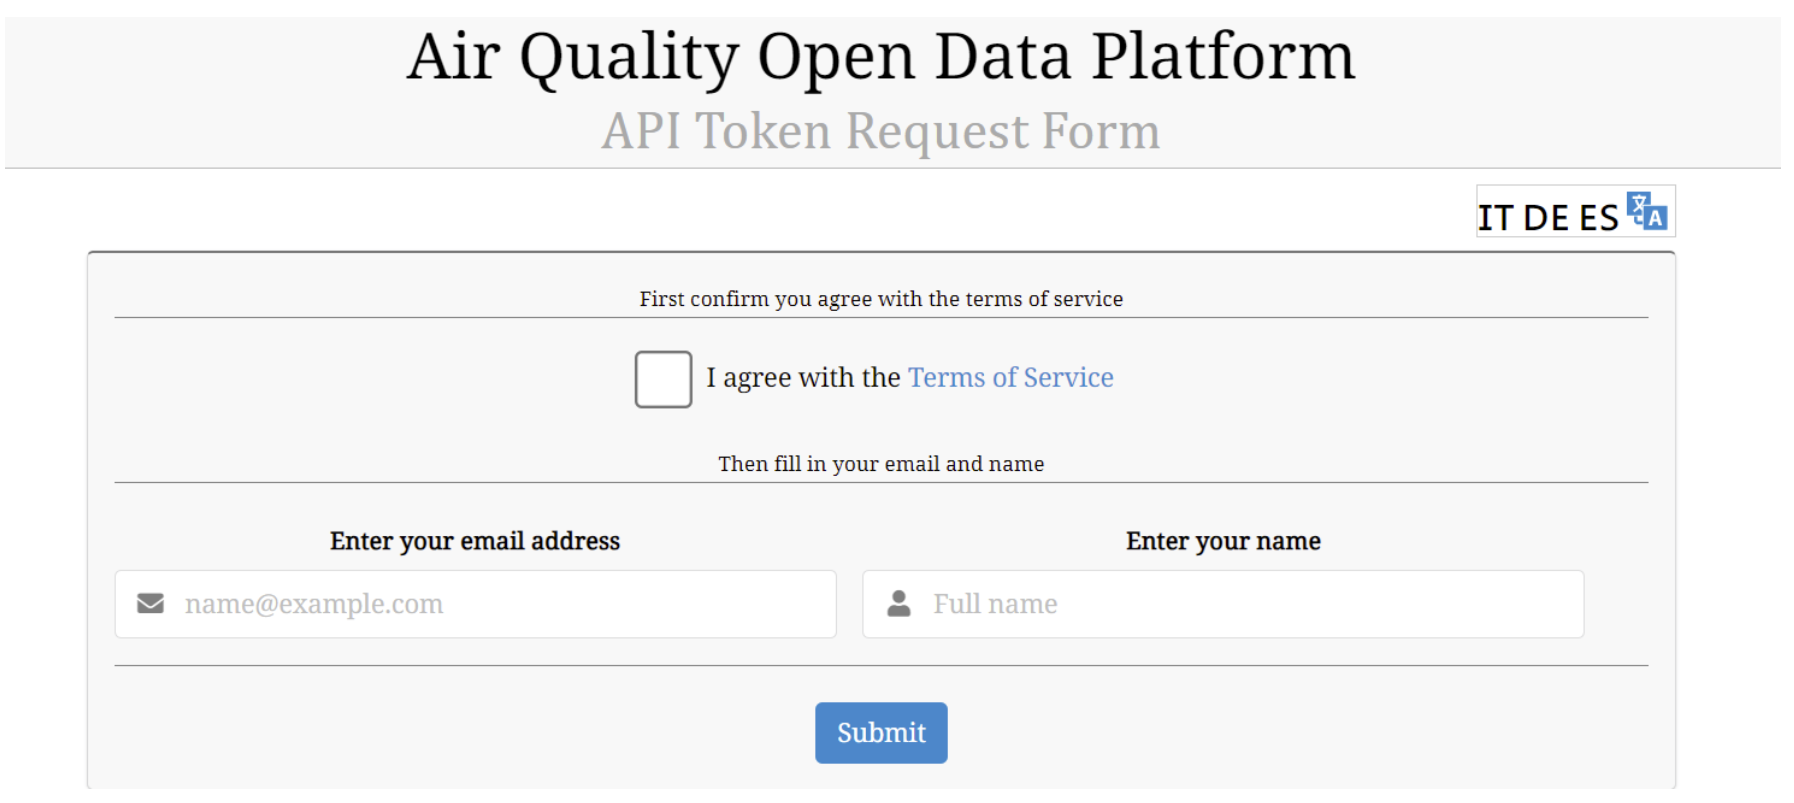

## <span style='color:#ff5f27'> 🌍 STEP 5: Store the AQI API Token as a Secret in Hopsworks </span>

Enter it as a Secret in the Hopsworks UI with the name `AQI_API_KEY` and the value field containing the token string itself

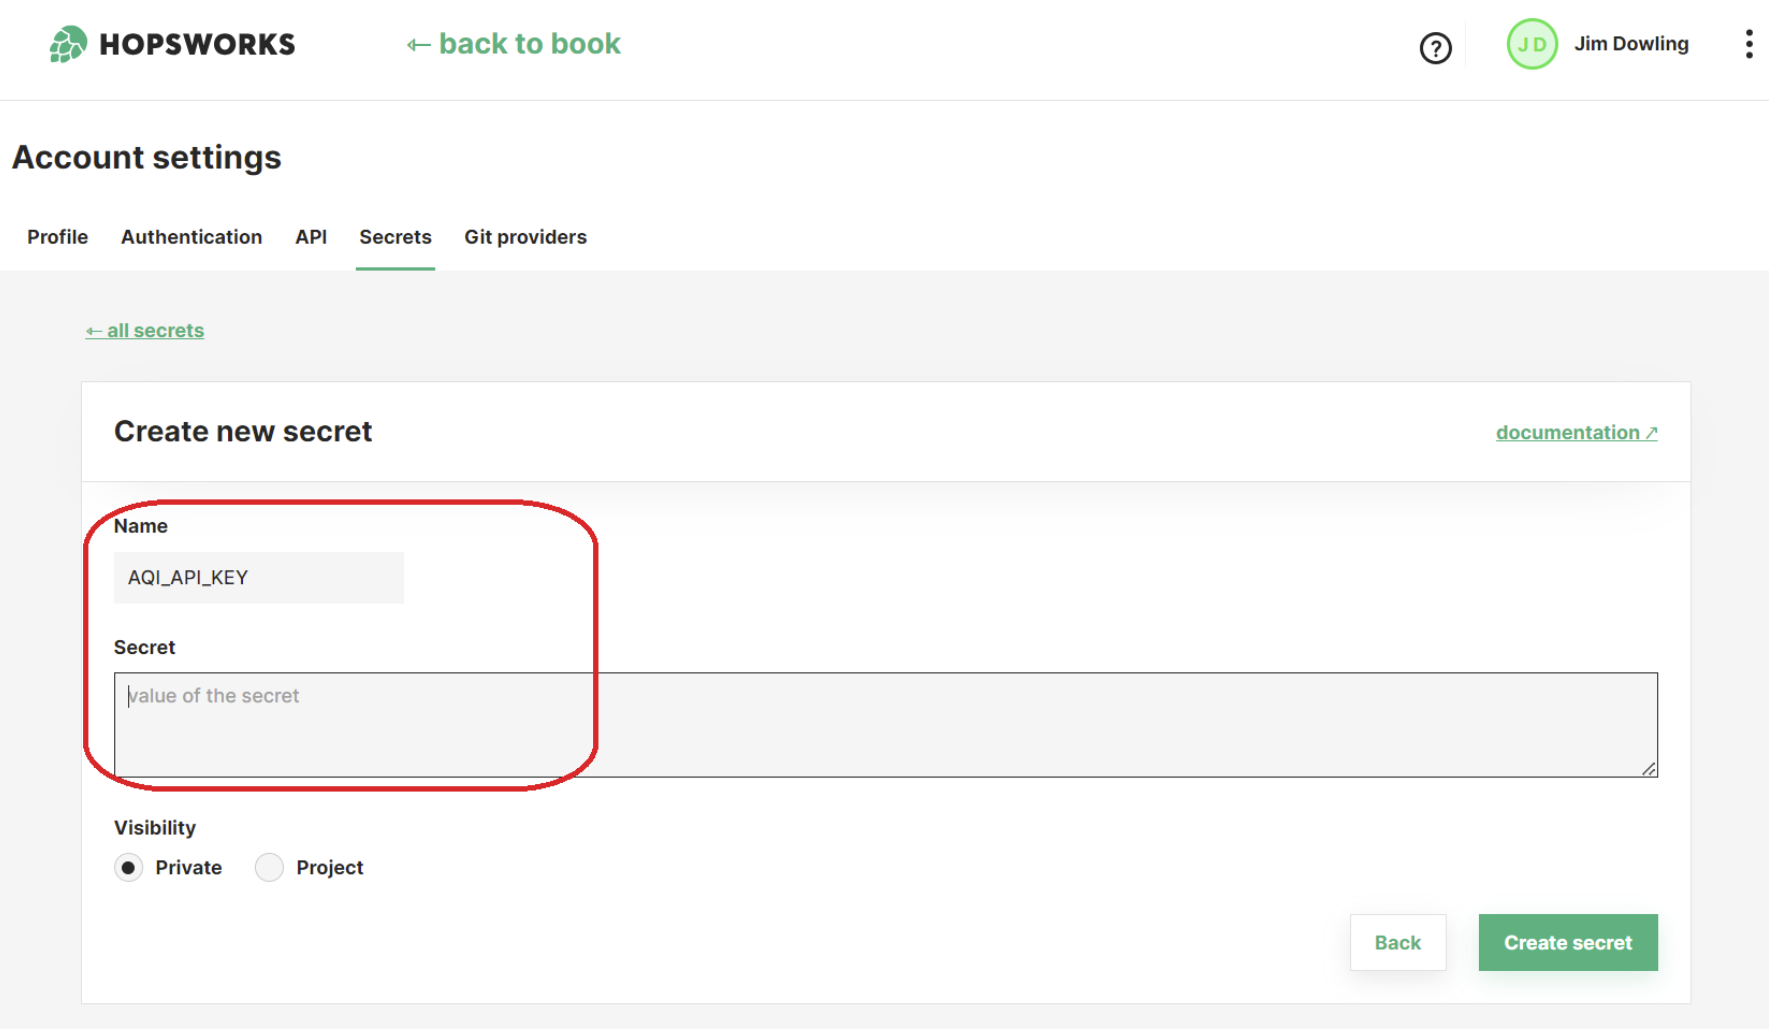

## <span style='color:#ff5f27'> 🌍 STEP 6: Read your CSV file into a DataFrame </span>

The cell below will read up historical air quality data as a CSV file into a Pandas DataFrame

In [4]:
df = pd.read_csv(csv_file,  parse_dates=['date'], skipinitialspace=True)
df

,date,min,max,pm25,q1,q3,stdev,count
0,2019-07-12 00:00:00+00:00,6.61,26.00,14.19,11.65,17.22,3.484,264
1,2019-07-13 00:00:00+00:00,8.94,46.94,15.06,12.67,17.61,4.189,715
2,2019-07-14 00:00:00+00:00,7.75,50.39,13.69,11.41,16.14,3.940,628
3,2019-07-15 00:00:00+00:00,2.88,40.99,6.22,5.16,7.90,3.933,715
4,2019-07-16 00:00:00+00:00,4.71,31.09,11.39,8.11,15.29,4.308,716
...,...,...,...,...,...,...,...,...
1563,2024-04-29 00:00:00+00:00,15.00,35.00,22.90,20.70,25.30,3.321,665
1564,2024-04-30 00:00:00+00:00,9.00,39.80,17.80,15.40,32.30,9.434,663
1565,2024-05-01 00:00:00+00:00,3.20,37.40,15.00,12.70,20.15,7.207,660
1566,2024-05-02 00:00:00+00:00,12.20,36.10,18.90,16.20,22.40,4.989,668


## Check the data types for the columns in your DataFrame

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1568 entries, 0 to 1567
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    1568 non-null   datetime64[ns, UTC]
 1   min     1568 non-null   float64            
 2   max     1568 non-null   float64            
 3   pm25    1568 non-null   float64            
 4   q1      1568 non-null   float64            
 5   q3      1568 non-null   float64            
 6   stdev   1568 non-null   float64            
 7   count   1568 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 98.1 KB


## <span style='color:#ff5f27'> 🌍 STEP 7: Drop any rows with missing data </span>
It will make the model training easier if there is no missing data in the rows, so we drop any rows with missing data.

In [6]:
df.dropna(inplace=True)
df

,date,min,max,pm25,q1,q3,stdev,count
0,2019-07-12 00:00:00+00:00,6.61,26.00,14.19,11.65,17.22,3.484,264
1,2019-07-13 00:00:00+00:00,8.94,46.94,15.06,12.67,17.61,4.189,715
2,2019-07-14 00:00:00+00:00,7.75,50.39,13.69,11.41,16.14,3.940,628
3,2019-07-15 00:00:00+00:00,2.88,40.99,6.22,5.16,7.90,3.933,715
4,2019-07-16 00:00:00+00:00,4.71,31.09,11.39,8.11,15.29,4.308,716
...,...,...,...,...,...,...,...,...
1563,2024-04-29 00:00:00+00:00,15.00,35.00,22.90,20.70,25.30,3.321,665
1564,2024-04-30 00:00:00+00:00,9.00,39.80,17.80,15.40,32.30,9.434,663
1565,2024-05-01 00:00:00+00:00,3.20,37.40,15.00,12.70,20.15,7.207,660
1566,2024-05-02 00:00:00+00:00,12.20,36.10,18.90,16.20,22.40,4.989,668


## <span style='color:#ff5f27'> 🌍 STEP 8: Drop unnecessary columns and add country, city, street to the DataFrame </span>

Your CSV file may have many other air quality measurement columns. We will only work with the `pm25` column.

We add the columns for the country, city, and street names that you changed for your Air Quality sensor.

We also want to make sure the `pm25` column is a float32 data type.

In [7]:
# Your sensor may have columns we won't use, so only keep the date and pm25 columns
# If the column names in your DataFrame are different, rename your columns to `date` and `pm25`
df_aq = df[['date', 'pm25']]
df_aq['country']=country
df_aq['city']=city
df_aq['street']=street
df_aq['url']=aqicn_url

# Cast the pm25 column to be a float32 data type
df_aq['pm25'] = df_aq['pm25'].astype('float32')

---

## <span style='color:#ff5f27'> 🌦 Loading Weather Data from [Open Meteo](https://open-meteo.com/en/docs)

## <span style='color:#ff5f27'> 🌍 STEP 9: Download the Historical Weather Data </span>

https://open-meteo.com/en/docs/historical-weather-api#hourly=&daily=temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant

We will download the historical weather data for your `city` by first extracting the earliest date from your DataFrame containing the historical air quality measurements.

We will download all daily historical weather data measurements for your `city` from the earliest date in your air quality measurement DataFrame. It doesn't matter if there are missing days of air quality measurements. We can store all of the daily weather measurements, and when we build our training dataset, we will join up the air quality measurements for a given day to its weather features for that day. 

The weather features we will download are:

 * `temperature (average over the day)`
 * `precipitation (the total over the day)`
 * `wind speed (average over the day)`
 * `wind direction (the most dominant direction over the day)`


In [8]:
earliest_aq_date = pd.Series.min(df_aq['date'])
earliest_aq_date = earliest_aq_date.strftime('%Y-%m-%d')
earliest_aq_date

weather_df = util.get_historical_weather(city, earliest_aq_date, str(today))

Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 27.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [9]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1757 entries, 0 to 1756
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         1757 non-null   datetime64[ns]
 1   temperature_2m_mean          1757 non-null   float32       
 2   precipitation_sum            1757 non-null   float32       
 3   wind_speed_10m_max           1757 non-null   float32       
 4   wind_direction_10m_dominant  1757 non-null   float32       
 5   city                         1757 non-null   object        
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 68.6+ KB


## <span style='color:#ff5f27'> 🌍 STEP 10: Define Data Validation Rules </span>

We will validate the air quality measurements (`pm25` values) before we write them to Hopsworks.

We define a data validation rule (an expectation in Great Expectations) that ensures that `pm25` values are not negative or above the max value available by the sensor.

We will attach this expectation to the air quality feature group, so that we validate the `pm25` data every time we write a DataFrame to the feature group. We want to prevent garbage-in, garbage-out.

In [10]:
import great_expectations as ge
aq_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="aq_expectation_suite"
)

aq_expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"pm25",
            "min_value":-0.1,
            "max_value":500.0,
            "strict_min":True
        }
    )
)

{"expectation_type": "expect_column_min_to_be_between", "kwargs": {"column": "pm25", "min_value": -0.1, "max_value": 500.0, "strict_min": true}, "meta": {}}

## Expectations for Weather Data
Here, we define an expectation for 2 columns in our weather DataFrame - `precipitation_sum` and `wind_speed_10m_max`, where we expect both values to be greater than zero, but less than 1000.

In [11]:
import great_expectations as ge
weather_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="weather_expectation_suite"
)

def expect_greater_than_zero(col):
    weather_expectation_suite.add_expectation(
        ge.core.ExpectationConfiguration(
            expectation_type="expect_column_min_to_be_between",
            kwargs={
                "column":col,
                "min_value":-0.1,
                "max_value":1000.0,
                "strict_min":True
            }
        )
    )
expect_greater_than_zero("precipitation_sum")
expect_greater_than_zero("wind_speed_10m_max")

---

### <span style="color:#ff5f27;"> 🔮 STEP 11: Connect to Hopsworks and save the sensor country, city, street names as a secret</span>

In [12]:
import hopsworks

project = hopsworks.login()
fs = project.get_feature_store() 

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
Connected. Call `.close()` to terminate connection gracefully.


### Validate that the AQI_API_KEY you added earlier works

In [13]:
secrets = util.secrets_api(project.name)
try:
    AQI_API_KEY = secrets.get_secret("AQI_API_KEY").value
    aq_today_df = util.get_pm25(aqicn_url, country, city, street, today, AQI_API_KEY)
except hopsworks.RestAPIError:
    print("It looks like you made a mistake when adding AQI_API_KEY as a secret in Hopsworks")

aq_today_df.head()

Connected. Call `.close()` to terminate connection gracefully.


,pm25,country,city,street,date,url
0,25.0,usa,new york,51st and 8th,2024-05-04,https://api.waqi.info/feed/A36655


#### Save country, city, street names as a secret

These will be downloaded from Hopsworks later in the (1) daily feature pipeline and (2) the daily batch inference pipeline

In [14]:
dict_obj = {
    "country": country,
    "city": city,
    "street": street,
    "aqicn_url": aqicn_url
}

# Convert the dictionary to a JSON string
str_dict = json.dumps(dict_obj)

try:
    secrets.create_secret("SENSOR_LOCATION_JSON", str_dict)
except hopsworks.RestAPIError:
    print("SENSOR_LOCATION_JSON already exists. If you want to update it, delete the secret in the Hopworks UI and re-run.")
    existing_key = secrets.get_secret("SENSOR_LOCATION_JSON").value
    print(f"{existing_key}")

SENSOR_LOCATION_JSON already exists. If you want to update it, delete the secret in the Hopworks UI and re-run.
{"country": "usa", "city": "new york", "street": "51st and 8th", "aqicn_url": "https://api.waqi.info/feed/A36655"}


### <span style="color:#ff5f27;"> 🔮 STEP 12: Create the Feature Groups and insert the DataFrames in them </span>

### <span style='color:#ff5f27'> 🌫 Air Quality Data
    
 1. Provide a name, description, and version for the feature group.
 2. Define the `primary_key`: we have to select which columns uniquely identify each row in the DataFrame - by providing them as the `primary_key`. Here, each air quality sensor measurement is uniquely identified by `country`, `street`, and  `date`.
 3. Define the `event_time`: We also define which column stores the timestamp or date for the row - `date`.
 4. Attach any `expectation_suite` containing data validation rules

In [15]:
air_quality_fg = fs.get_or_create_feature_group(
    name='air_quality',
    description='Air Quality characteristics of each day',
    version=1,
    primary_key=['country','street'],
    event_time="date",
    expectation_suite=aq_expectation_suite
)

#### Insert the DataFrame into the Feature Group

In [16]:
air_quality_fg.insert(df_aq)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/780658
2024-05-04 20:20:52,191 INFO: 	1 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/398/fs/335/fg/780658


Uploading Dataframe: 0.00% |          | Rows 0/1568 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/air_quality_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fac74e4f370>,
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_between",
         "kwargs": {
           "column": "pm25",
           "min_value": -0.1,
           "max_value": 500.0,
           "strict_min": true
         },
         "meta": {
           "expectationId": 489497
         }
       },
       "result": {
         "observed_value": 0.4000000059604645,
         "element_count": 1568,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2024-05-04T06:20:52.000191Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     }
   ],
   "evaluation_parameters": {},
   "statistics": {
     "evaluated_expectations": 1,
     "successful_expectatio

#### Enter a description for each feature in the Feature Group

In [17]:
air_quality_fg.update_feature_description("date", "Date of measurement of air quality")
air_quality_fg.update_feature_description("country", "Country where the air quality was measured (sometimes a city in acqcn.org)")
air_quality_fg.update_feature_description("city", "City where the air quality was measured")
air_quality_fg.update_feature_description("street", "Street in the city where the air quality was measured")
air_quality_fg.update_feature_description("pm25", "Particles less than 2.5 micrometers in diameter (fine particles) pose health risk")

### <span style='color:#ff5f27'> 🌦 Weather Data
    
 1. Provide a name, description, and version for the feature group.
 2. Define the `primary_key`: we have to select which columns uniquely identify each row in the DataFrame - by providing them as the `primary_key`. Here, each weather measurement is uniquely identified by `city` and  `date`.
 3. Define the `event_time`: We also define which column stores the timestamp or date for the row - `date`.
 4. Attach any `expectation_suite` containing data validation rules

In [18]:
# Get or create feature group 
weather_fg = fs.get_or_create_feature_group(
    name='weather',
    description='Weather characteristics of each day',
    version=1,
    primary_key=['city'],
    event_time="date",
    expectation_suite=weather_expectation_suite
) 

#### Insert the DataFrame into the Feature Group

In [19]:
# Insert data
weather_fg.insert(weather_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/780659
2024-05-04 20:21:05,915 INFO: 	2 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/398/fs/335/fg/780659


Uploading Dataframe: 0.00% |          | Rows 0/1757 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/weather_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fabe38f40a0>,
 {
   "success": true,
   "results": [
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_between",
         "kwargs": {
           "column": "precipitation_sum",
           "min_value": -0.1,
           "max_value": 1000.0,
           "strict_min": true
         },
         "meta": {
           "expectationId": 489499
         }
       },
       "result": {
         "observed_value": 0.0,
         "element_count": 1757,
         "missing_count": null,
         "missing_percent": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2024-05-04T06:21:05.000915Z"
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       }
     },
     {
       "success": true,
       "expectation_config": {
         "expectation_type": "expect_column_min_to_be_be

#### Enter a description for each feature in the Feature Group

In [20]:
weather_fg.update_feature_description("date", "Date of measurement of weather")
weather_fg.update_feature_description("city", "City where weather is measured/forecast for")
weather_fg.update_feature_description("temperature_2m_mean", "Temperature in Celsius")
weather_fg.update_feature_description("precipitation_sum", "Precipitation (rain/snow) in mm")
weather_fg.update_feature_description("wind_speed_10m_max", "Wind speed at 10m abouve ground")
weather_fg.update_feature_description("wind_direction_10m_dominant", "Dominant Wind direction over the dayd")

## <span style="color:#ff5f27;">⏭️ **Next:** Part 02: Daily Feature Pipeline 
 </span> 


## <span style="color:#ff5f27;">⏭️ **Exercises:** 
 </span> 

Extra Homework:

  * Add a rolling window of 3 days and 5 days for 'pm25'
  * df.set_index("date").rolling(3).mean().head()


---